In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import sympy.physics.mechanics as me
#from sympy import sin, cos, symbols, solve, Matrix
#from scipy.integrate import odeint
from IPython.display import SVG
import time
me.init_vprinting()#(use_latex='mathjax')
#from sympy.interactive import printing
#printing.init_printing(use_latex=True)

In [2]:
def mprint(d):
    print(me.vlatex(d))
    return d
    

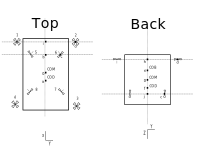

In [3]:
#right hand system & thrust positive down and forward
SVG(filename='RovVision2v1.svg')

<IPython.core.display.Javascript object>


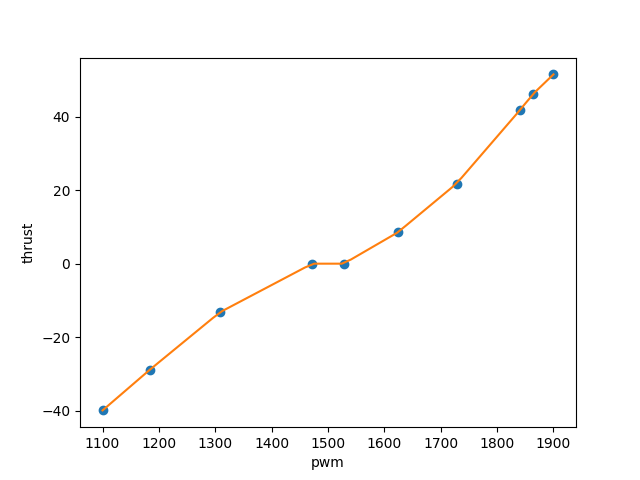

array([-3.99129173,  0.        ])

In [4]:
#thruster model
from scipy.interpolate import interp1d
pts_16v_t200 = [(1100,-4.07) , (1184, -2.94), (1308, -1.35) , (1472,0) , (1528,0), 
                (1624,0.87) , (1728,2.22), (1840,4.25), (1864,4.71), (1900,5.25)]
pwm,thrust = zip(*pts_16v_t200)
thrust=np.array(thrust)/0.101972 #kgf to newton
pwm_to_thrust=interp1d(pwm, thrust)
def scale_thrust(control):
    return np.array([pwm_to_thrust(c*400+1500)/10 for c in control])

plt.figure('thrust pwm')
pwmnew = np.linspace(1100, 1900, num=50, endpoint=True)
plt.plot(pwm, thrust, 'o', pwmnew, pwm_to_thrust(pwmnew), '-')
#plt.legend(['data', 'linear'], loc='best')
plt.xlabel('pwm')
plt.ylabel('thrust')
plt.show()
#pwm_to_thrust(1600)
scale_thrust([-1,0.05])

# Define Variables

constants:

- $m_A$: Mass of the Rov.
- $a,b,c,d,e,f,g,h,i$: reltive coords wrt COM

In [5]:
# Inertial Reference Frame
N = me.ReferenceFrame('N')

# Define a world coordinate origin
O = me.Point('O')
O.set_vel(N, 0)

\left[\begin{matrix}- u_{0} + \dot{q}_{0}\\- u_{1} + \dot{q}_{1}\\- u_{2} + \dot{q}_{2}\\- u_{3} + \dot{q}_{3}\\- u_{4} + \dot{q}_{4}\\- u_{5} + \dot{q}_{5}\end{matrix}\right]


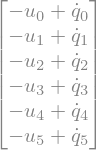

In [6]:
#generelized coordinates
#q0..3 = xyz positions  q4..6 = roll,pitch,yaw rotations
q = list(me.dynamicsymbols('q0:6'))
#generlized speeds
u = list(me.dynamicsymbols('u0:6'))

kin_diff=Matrix(q).diff()-Matrix(u)
#print(me.vlatex(kin_diff))
mprint(kin_diff)

In [7]:
# Constants for the ROV Body

m_b = symbols('m_b')                                 # Mass of the body
v_b = symbols('v_b') # Volume of the body
mux = symbols('\mu_x') #drag
muy = symbols('\mu_y') #drag
muz = symbols('\mu_z') #drag
mu_r = symbols('\mu_r') #rotational drag
g = symbols('g')
I = list(symbols('Ixx, Iyy, Izz'))             # Moments of inertia of body
a,b,c,d,e,f,h,i,j = symbols(list('abcdefhij'))

In [8]:
# Robot Reference Frame
Rz=N.orientnew('R_z', 'Axis', (q[3+0], N.z))
Rz.set_ang_vel(N,u[3+0]*N.z)

Ry=Rz.orientnew('R_y', 'Axis', (q[3+1], Rz.y))
Ry.set_ang_vel(Rz,u[3+1]*Rz.y)

R=Ry.orientnew('R', 'Axis', (q[3+2], Ry.x))
R.set_ang_vel(Ry,u[3+2]*Ry.x)


# Center of mass of body
COM = O.locatenew('COM', q[0]*N.x + q[1]*N.y + q[2]*N.z)

# Set the velocity of COM
COM.set_vel(N, u[0]*N.x + u[1]*N.y + u[2]*N.z)

#center of bouyency
COB = COM.locatenew('COB', -R.z*e)
COB.v2pt_theory(COM, N, R);
COD = COM.locatenew('COD', -R.z*f-R.x*a)
COD.v2pt_theory(COM, N, R);


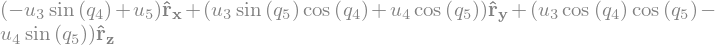

In [9]:
### next 3 cells for calculating conversion from angular rates to euler rates
#str(R.ang_vel_in(N).express(R).to_matrix(R)).replace('(t)','')
R.ang_vel_in(N).express(R)

In [10]:
from sympy import Matrix
#the next matrix I created manually from the output of the prev cell
MM=Matrix([[0, -sin(q[3]), cos(q[3])*cos(q[4])],
        [0, cos(q[3]), sin(q[3])*cos(q[4])],
        [1,0,-sin(q[4])]])
MM*Matrix([[u[3],u[4],u[5]]]).T
MMI=MM.inv()

In [11]:
MMI.simplify()
#should print the final matrix
print(MMI)

Matrix([[cos(q3(t))*tan(q4(t)), sin(q3(t))*tan(q4(t)), 1], [-sin(q3(t)), cos(q3(t)), 0], [cos(q3(t))/cos(q4(t)), sin(q3(t))/cos(q4(t)), 0]])


In [12]:
# Calculate inertia of body
#for the products of inertia we assume symetric body => ixy=0, iyz=0, izx=0
Ib = me.inertia(R, *I , ixy=0, iyz=0, izx=0)
# Create a rigid body object for body
Body = me.RigidBody('Body', COM, R, m_b, (Ib, COM))
Ib

In [13]:
# Points of thrusters
L1 = COM.locatenew('L_1', -R.y*d+R.x*i-R.z*h)
L2 = COM.locatenew('L_2', R.y*d+R.x*i-R.z*h)
L3 = COM.locatenew('L_3', R.y*d-R.x*i-R.z*h)
L4 = COM.locatenew('L_4', -R.y*d-R.x*i-R.z*h)
L5 = COM.locatenew('L_5', -R.y*c +R.x*b+R.z*j)
L6 = COM.locatenew('L_6',  R.y*c +R.x*b+R.z*j)
L7 = COM.locatenew('L_7', R.y*c-R.x*b+R.z*j)
L8 = COM.locatenew('L_8', -R.y*c-R.x*b+R.z*j)

# Set the velocity of points 
L1.v2pt_theory(COM, N, R)
L2.v2pt_theory(COM, N, R)
L3.v2pt_theory(COM, N, R);
L4.v2pt_theory(COM, N, R);
L5.v2pt_theory(COM, N, R);
L6.v2pt_theory(COM, N, R);
L7.v2pt_theory(COM, N, R);
L8.v2pt_theory(COM, N, R);


## Calculating hydrodynamic drag

https://en.wikipedia.org/wiki/Drag_(physics)

for slow moving objects with non turbulant flow the drag is proportional to the velocity and can be written as:

$F_{D}\,=\mu \,v$

In [14]:
#v=N.x*u[0]+N.y*u[1]+N.z*u[2]
Fd=-u[0]*mux*N.x -u[1]*N.y*muy -u[2]*muz*N.z
Fd

In [15]:
#thrust forces symbols
F1, F2, F3, F4, F5, F6, F7, F8 = symbols('f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8') 
Fg = -N.z *m_b * g
Fb = N.z * v_b * 1e3 *g #whight of 1m^3 water in kg (MKS units)
mprint(Fb)

1000.0 g v_{b}\mathbf{\hat{n}_z}


In [16]:
#### adding dumping Torqe for each rotation

#T_z=(Rz,-u[3+2]*N.z*mu_r) #rotaional dumping Torqe
#T_y=(Ry,-u[3+1]*Rz.y*mu_r) #rotaional dumping Torqe
#T_x=(R,-u[3+0]*Ry.x*mu_r) #rotaional dumping Torqe
#T = (R, -(u[3+0]*Ry.x+u[3+1]*Rz.y+u[3+2]*N.z)*mu_r)
#T = (R, -(u[3+0]*N.z+u[3+1]*Rz.y+u[3+2]*R.x)*mu_r)
T = (R, -R.ang_vel_in(N)*mu_r)
mprint(T[1])

-  \mu_{r} u_{5}\mathbf{\hat{r_y}_x} -  \mu_{r} u_{4}\mathbf{\hat{r_z}_y} -  \mu_{r} u_{3}\mathbf{\hat{n}_z}


In [17]:
#currents effect 
# for now only leanear
cx,cy,cz=symbols('c_x,c_y,c_z')
Fc=cx*N.x+cy*N.y+cz*N.z
Fc

In [18]:
kane = me.KanesMethod(N, q_ind=q, u_ind=u, kd_eqs=kin_diff)

In [19]:
sq2=0.7#np.sqrt(2)/2
bodies = (Body,)
ta = np.deg2rad(45)
#ta = np.deg2rad(20)
c_ta = np.cos(ta)
s_ta = np.sin(ta)
loads = (
    (L1, F1 * R.z),
    (L2, F2 * R.z),
    (L3, F3 * R.z), 
    (L4, F4 * R.z), 
    (L5, sq2 * F5 * (R.x*c_ta + R.y*s_ta)), 
    (L6, sq2 * F6 * (R.x*c_ta - R.y*s_ta)), 
    (L7, sq2 * F7 * (R.x*c_ta + R.y*s_ta)), 
    (L8, sq2 * F8 * (R.x*c_ta - R.y*s_ta)), 
    (COM, Fg ), 
    (COB, Fb ), 
    (COD, Fd + Fc),
    T
    )

fr, frstar = kane.kanes_equations(loads=loads, bodies=bodies)

In [20]:
#u_dot=trigsimp(trigsimp(kane.mass_matrix).inv()*trigsimp(kane.forcing))
u_dot=kane.mass_matrix.inv()*kane.forcing
u_dot.atoms(Symbol)

In [21]:
mprint(F1 * R.x)

f_{1}\mathbf{\hat{r}_x}


In [22]:
if 0:
    km_simp=trigsimp(kane.mass_matrix)
    kf_simp=trigsimp(kane.forcing)
#mprint(kf_simp)

In [23]:
_subs=[(a,0.0),
    (b,0.20),
    (c,0.20), #c & b should be the sae value to achive 45 deg from COM
    (d,0.15),
    (e,0.00),
    (f,0.00),
    (h,0.00),
    (i,0.20),
    (j,0.00),
    (m_b,1.0*12), #1
    (v_b,0.001*12), #0.001
    (mux,6.2),
    (muy,6.2),
    (muz,6.2),
    (mu_r,4.5),
    (g,9.8), #9.8
    (I[0],1.2),
    (I[1],1.2),
    (I[2],1.2)
     ]#mprint(kf_simp[4])
#u_dot_simp[1]
subs=[(a,0.0),
    (b,0.20),
    (c,0.20), #c & b should be the sae value to achive 45 deg from COM
    (d,0.15),
    (e,-0.003),
    (f,0.00),
    (h,-0.02),
    (i,0.20),
    (j,0.03),
    (m_b,1.0*12), #1
    (v_b,0.001*11.98), #0.001
    (mux,6.2),
    (muy,6.2),
    (muz,6.2),
    (mu_r,4.5),
    (g,9.8), #9.8
    (I[0],1.2),
    (I[1],1.2),
    (I[2],1.2)
     ]#mprint(kf_simp[4])

subs=[(a,0.0),
    (b,0.20),
    (c,0.20), #c & b should be the sae value to achive 45 deg from COM
    (d,0.15),
    (e,-0.003),
    (f,0.00),
    (h,-0.02),
    (i,0.20),
    (j,0.03),
    (m_b,1.0*12), #1
    (v_b,0.001*11.98), #0.001
    (mux,6.2),
    (muy,6.2),
    (muz,6.2),
    (mu_r,4.5),
    (g,9.8), #9.8
    (I[0],1.2),
    (I[1],1.2),
    (I[2],1.2)
     ]#mprint(kf_simp[4])

subs=[(a,0.0),
    (b,0.20),
    (c,0.20), #c & b should be the sae value to achive 45 deg from COM
    (d,0.15),
    (e,-0.10),
    (f,0.00),
    (h,-0.02),
    (i,0.20),
    (j,0.03),
    (m_b,1.0*18), #1
    (v_b,0.001*17.9999), #0.001
    (mux,10*1),
    (muy,10*2),
    (muz,10*2),
    (mu_r,7),
    (g,9.8), #9.8
    (I[0],1.2),
    (I[1],1.2),
    (I[2],1.2)
     ]#mprint(kf_simp[4])

u_dot_simp=u_dot.subs(subs)
#u_dot_simp=trigsimp(u_dot_simp)


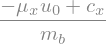

In [24]:
#dump
#import dill
#dill.settings['recurse'] = True
#dill.dump(u_dot,open('udot.pkl','wb'))
u_dot[0].subs([(F1,0),(F2,0),(F3,0),(F4,0),(F5,0),(F6,0),(F7,0),(F8,0)])

In [25]:
u_dot.atoms(Symbol)

In [26]:
from sympy import lambdify
def get_next_state_lambda():
    return lambdify((q,u,F1,F2,F3,F4,F5,F6,F7,F8,cx,cy,cz),u_dot_simp)

def get_next_state(curr_q,curr_u,control,curr_t,dt,lamb):
    forces=control(curr_t)
    u_dot_f=lamb(curr_q,curr_u,*forces).flatten()
    next_q=curr_q+curr_u*dt
    next_u=curr_u+u_dot_f*dt
    return next_q,next_u
#test lambdify
qq=np.zeros(6)
uu=np.zeros(6)
lamb=get_next_state_lambda()
lamb(qq,uu,0,0,0,0,1,-1,-1,1,0,0,0)
#lamb(qq,uu,0,0,0,0,1,1,1,1)


array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [-5.44444444e-05],
       [ 6.59966329e-01],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [27]:
#dump
import dill
dill.settings['recurse'] = True
dill.dump(lamb,open('../sim/lambda.pkl','wb'))

In [38]:
def plot(t,y):
    plt.figure()
    plt.subplot(2,2,1)
    plt.plot(t, y[:, :3])
    plt.legend([latex(s, mode='inline') for s in 'xyz'])
    plt.xlabel('[sec]')
    plt.ylabel('[meters]')
    plt.title('a) Position vs Time')
    plt.subplot(2,2,2)
    plt.plot(t, np.rad2deg(y[:, 3:6]))
    plt.legend([latex(s, mode='inline') for s in 'ypr'])
    plt.xlabel('[sec]')
    plt.ylabel('[deg]')
    plt.title('b) Rotations vs Time')
    plt.subplot(2,2,3)
    plt.xlabel('[meters]')
    plt.ylabel('[meters]')
    plt.title('c) XY plane plot')
    plt.plot(y[:,0],y[:,1])
    plt.axis('equal')
    plt.subplot(2,2,4)
    plt.plot(t, np.rad2deg(y[:, 9:12]))
    plt.legend([latex(s, mode='inline') for s in ['Rz','Ry','Rx']])
    plt.xlabel('[sec]')
    plt.ylabel('[deg/sec]')
    plt.title('d) Angular velocities')
    

In [29]:
def sim(controller, curr_q=None):
    if curr_q is None:
        curr_q = np.zeros(6)
    curr_u = np.zeros(6)
    frames_per_sec = 60.0
    final_time = 300.0
    dt=1.0/frames_per_sec
    y=[]
    curr_time=0
    t = np.linspace(0.0, final_time, int(final_time * frames_per_sec))
    lamb=get_next_state_lambda()
    for curr_time in t:
        #next_q,next_u=get_next_state(curr_q,curr_u,controller,curr_time,dt,subs)
        next_q,next_u=get_next_state(curr_q,curr_u,controller,curr_time,dt,lamb)
        next_q,next_u=next_q.flatten(),next_u.flatten()
        #next_u=np.clip(next_u,-0.1,0.1)
        y.append(np.hstack((next_q,next_u)))
        curr_q,curr_u=next_q,next_u
        #print(next_u)
    y=np.array(y,dtype='float32')
    return(t,y)


In [30]:
_=pwm_to_thrust
def controller1(t):
    if t<10:
        return [0]*4+[0]*4+[0]*3
    elif t<80:
        return [_(1500)]*4+[_(1600)]*4 +[0,0,0] #fwd
        #return [0,0,0,0,1,-1,-1,1,0,0,0] #rotate
        #return [0,0,0,0,1,-1,1,-1,0,0,0] #right
    else:
        return [0]*11

        #return [0.1]*4+[0]*4
#t,y=sim(controller1,np.array([0,0,0,-np.pi/2,0,0]))
t,y=sim(controller1,np.array([0,0,0,0,0,0]))
plot(t,y)
y[-1]

<IPython.core.display.Javascript object>

array([ 2.2165804e+01, -1.5043795e-17, -4.7342470e-01,  3.9924709e-17,
        0.0000000e+00, -0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -2.4499999e-05,  0.0000000e+00, -0.0000000e+00,  0.0000000e+00],
      dtype=float32)

In [31]:
def controller1(t):
    if t<10:
        return [0]*4+[0]*4+[0]*3
    elif t<80:
        return [0,0,0,0,1,1,1,1,np.sin(t/10*2*np.pi)*3,0,0] #fwd with currents
        #return [0,0,0,0,1,-1,-1,1,0,0,0] #rotate
        #return [0,0,0,0,1,-1,1,-1,0,0,0] #right
    else:
        return [0]*11

        #return [0.1]*4+[0]*4
#t,y=sim(controller1,np.array([0,0,0,-np.pi/2,0,0]))
t,y=sim(controller1,np.array([0,0,0,0,0,0]))
plot(t,y)
y[-1]

<IPython.core.display.Javascript object>

array([ 3.4648032e+00, -1.5433495e-17, -1.8722257e-02, -8.3845695e-19,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
       -2.4499999e-05, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
      dtype=float32)

In [32]:
def controller1(t):
    if t<10:
        return [0]*4+[1]*4
    elif t<20:
        return [0]*8
    elif t<40:
        return [0,0,0,0,1./8,-1./8,-1./8,1./8]
    elif t<60:
        return [0]*8
    elif t<90:
        return [0]*4+[1]*4
    else:
        return [0]*8

        #return [0.1]*4+[0]*4
t,y=sim(controller1)
plot(t,y)
y[-1]

TypeError: _lambdifygenerated() missing 3 required positional arguments: 'c_x', 'c_y', and 'c_z'

In [ ]:
#only rotation
def controller1(t):
    if t<20:
        return [0.0 for i in range(8)]
    else:
        return [0,0,0,0, 1+0.00,-1+0.00,-1+0.00,1+0.00]
        #return [0.1]*4+[0]*4
t,y=sim(controller1)
plot(t,y)
y[-1]

In [ ]:
# l ,r f ,b
def controller2(t):
    if t<10: #left
        return [0,0,0,0.0, -1,1,-1,1]
    elif t<20:
        return [0,0,0,0.0, 1,-1,1,-1]
    elif t<30:
        return [0,0,0,0.0, 1,1,1,1]
    else:
        return [0]*8
t,y=sim(controller2)
plot(t,y)

In [ ]:
# d,u
def controller3(t):
    if t<20: #left
        return [1,1,1,1, 0,0,0,0]
    else:
        return [-1,-1,-1,-1 ,0,0,0,0]
t,y=sim(controller3)
plot(t,y)

In [ ]:
# pitch 
def controller4(t):
    if t<20: #left
        return [1,1,-1,-1, 0,0,0,0]
    else:
        return [-1,-1,1,1 ,0,0,0,0]
t,y=sim(controller4)
plot(t,y)

In [ ]:
# roll 
def controller5(t):
    if t<20: #left
        return [1,-1,-1,1, 0,0,0,0]
    else:
        return [-1,1,1,-1 ,0,0,0,0]
t,y=sim(controller5)
plot(t,y)

In [ ]:
print(me.express(N.z,R))

In [ ]:
print(me.express(N.x,R))

In [ ]:
print(me.express(N.y,R))

In [ ]:
print(R.dcm(N))

In [ ]:
R.dcm(N).T.subs([(q[0],0),(q[1],np.pi/2),(q[2],0)])